In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the path to your dataset folder
data_dir = '/content/drive/MyDrive/DL/Image_dataset'
print("Dataset Folder:", data_dir)

Dataset Folder: /content/drive/MyDrive/DL/Image_dataset


In [3]:
import os
# Count images and print size
total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image formats
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)

Total images downloaded: 450


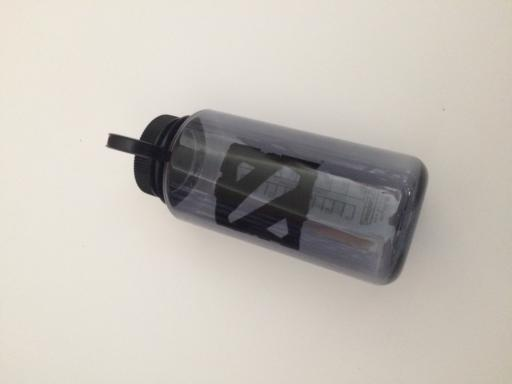

In [4]:
import pathlib
from PIL import Image

plastic_path = pathlib.Path(data_dir) / "plastic"  # Ensure correct path using pathlib
plastic_imgs = list(plastic_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(plastic_imgs[0]))

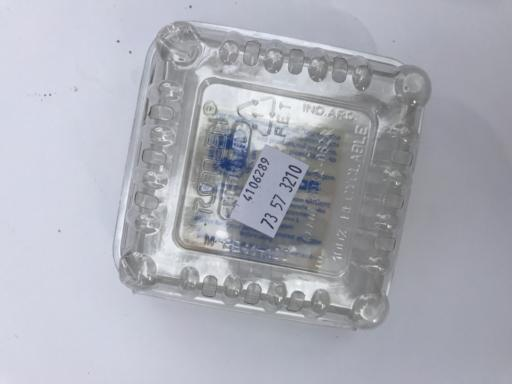

In [ ]:
Image.open(str(plastic_imgs[102]))

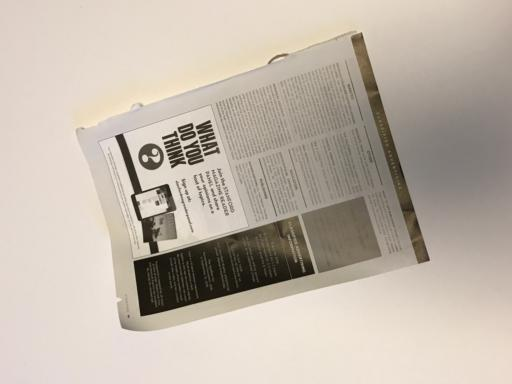

In [ ]:
paper_path = pathlib.Path(data_dir) / "paper"  # Ensure correct path using pathlib
paper_imgs = list(paper_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(paper_imgs[0]))

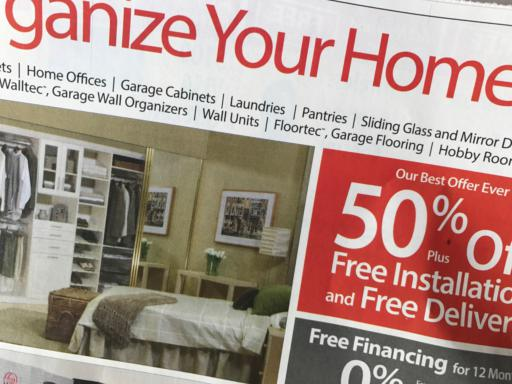

In [ ]:
Image.open(str(paper_imgs[5]))

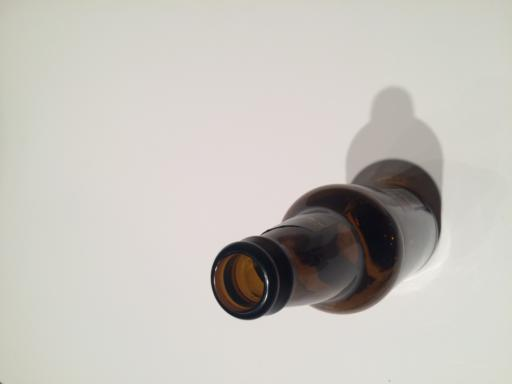

In [ ]:
glass_path = pathlib.Path(data_dir) / "glass"  # Ensure correct path using pathlib
glass_imgs = list(glass_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(glass_imgs[0]))

In [5]:
batch_size = 32

In [6]:
from torchvision import datasets, transforms

# 1. Load the dataset
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Rescale
])

In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(data_dir, transform = data_transform)
train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
# Count the total number of images
total_images = len(dataset)
print("Total images loaded:", total_images)

Total images loaded: 450


In [ ]:
print(len(train_dataset))

360


In [ ]:
print(len(val_dataset))

90


In [12]:
class_names = dataset.classes
print(class_names)

['glass', 'paper', 'plastic']


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

Visualize the data

visualizing first 12 images from the training dataset.

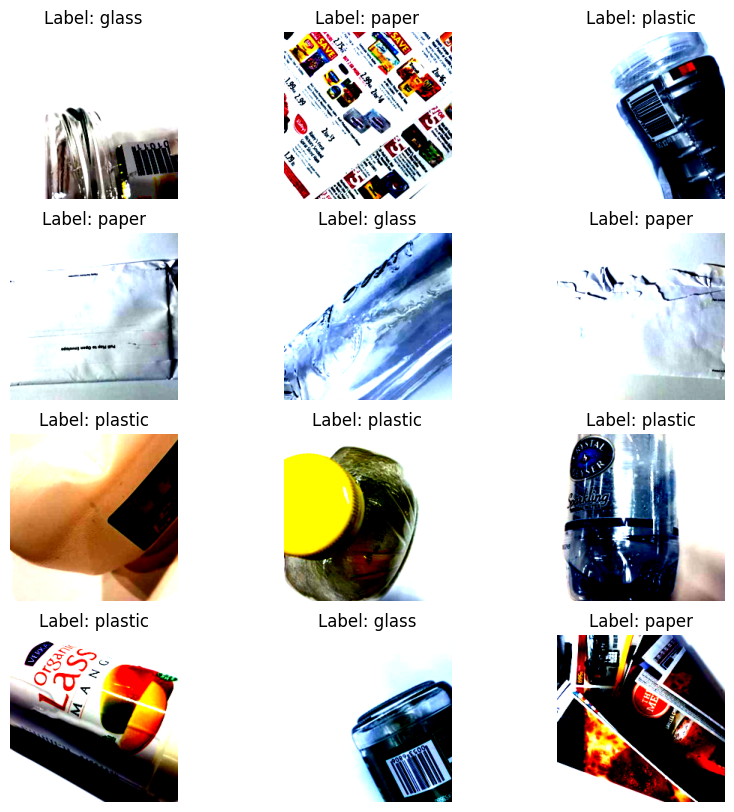

In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(12):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(4, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


In [ ]:
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
print(len(train_dataloader.dataset))
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)

360
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


Building CNN model

In [53]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = 5
model = CustomModel(num_classes)

# Print the model architecture
print(model)


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1605632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [54]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 224, 224
# Define the number of classes
num_classes = 5

# Instantiate the model
model = CNNModel(num_classes, img_height, img_width)


Compile the model: choosing the optimizers. Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, passing the metrics argument.

In [55]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 1.1169, Accuracy: 0.4083
Epoch 2/5, Loss: 0.8533, Accuracy: 0.6250
Epoch 3/5, Loss: 0.6765, Accuracy: 0.7139
Epoch 4/5, Loss: 0.4750, Accuracy: 0.8139
Epoch 5/5, Loss: 0.3480, Accuracy: 0.8861


Training the loop with Data Augmentation layers to avoid overfitting

In [56]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 3  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 0.6024, Accuracy: 0.7889
Epoch 2/3, Loss: 0.3545, Accuracy: 0.8750
Epoch 3/3, Loss: 0.2455, Accuracy: 0.9111


In [61]:
# Defining the evaluation function
def evaluate_model(model, val_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss

            # Compute validation accuracy
            acc = accuracy(outputs, labels)
            val_acc += acc.item() * images.size(0)

            # Track validation loss
            val_loss += loss.item() * images.size(0)

    # Calculate average loss and accuracy
    val_loss /= len(val_dataloader.dataset)
    val_acc /= len(val_dataloader.dataset)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Evaluating the model on the validation set
evaluate_model(model, val_dataloader, criterion)

Validation Loss: 1.0866, Accuracy: 0.6667


In [39]:
# Load and preprocess the unseen image
image_path = r"/content/drive/MyDrive/DL/Image_dataset/paper/paper106.jpg"  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [43]:
# Check if a GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

# Move the input batch to the same device as the model
input_batch = input_batch.to(device)

# Perform inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

# Calculate probabilities and confidence
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()

# Print the predicted class and confidence
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


This image most likely belongs to paper with a 59.75% confidence.


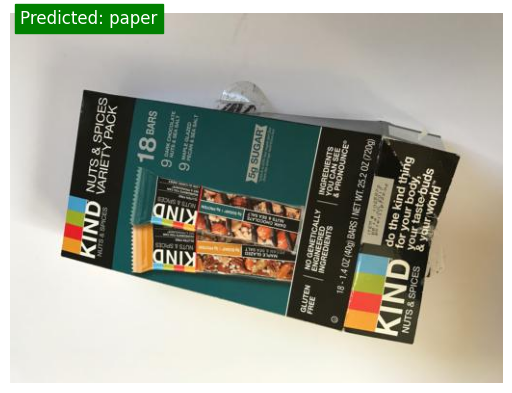

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [44]:
# Load and preprocess the unseen image
image_path = r"/content/drive/MyDrive/DL/Image_dataset/glass/glass10.jpg"  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [45]:
# Check if a GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

# Move the input batch to the same device as the model
input_batch = input_batch.to(device)

# Perform inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

# Calculate probabilities and confidence
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()

# Print the predicted class and confidence
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


This image most likely belongs to glass with a 87.42% confidence.


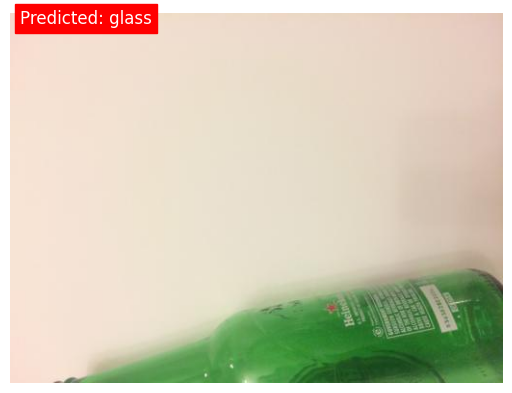

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [ ]:
# Load and preprocess the unseen image
image_path = r"/content/drive/MyDrive/DL/Image_dataset/plastic/plastic101.jpg"  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Check if a GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

# Move the input batch to the same device as the model
input_batch = input_batch.to(device)

# Perform inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

# Calculate probabilities and confidence
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()

# Print the predicted class and confidence
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


This image most likely belongs to plastic with a 51.59% confidence.


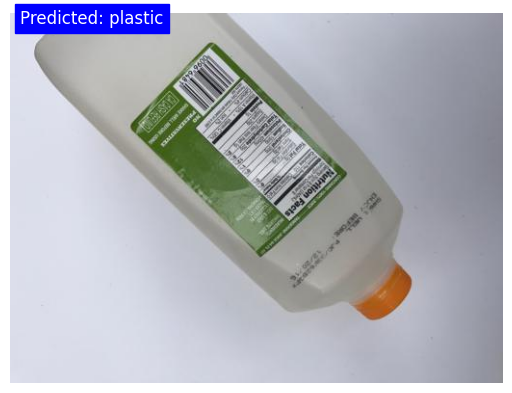

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='blue')
plt.show()

**Using GoogleNet**

In [49]:
import torch
import torchvision
from torchvision import transforms
from torch import nn

# Loading pre-trained GoogleNet model
googlenet = torchvision.models.googlenet(pretrained=True)

In [50]:
# Freezing  all layers excepting last one layer
for param in googlenet.parameters():
    param.requires_grad = False

# Replace the final classifier layer
num_features = googlenet.fc.in_features
num_classes = 3  # Adjust this to match your number of custom categories
googlenet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

In [51]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 5
# Defining the training loop
for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch [1/5], Loss: 0.9661, Accuracy: 49.44%
Epoch [2/5], Loss: 0.6711, Accuracy: 71.94%
Epoch [3/5], Loss: 0.5488, Accuracy: 77.22%
Epoch [4/5], Loss: 0.4649, Accuracy: 83.89%
Epoch [5/5], Loss: 0.3863, Accuracy: 84.72%


In [62]:
# Defining the evaluation function
def evaluate_googlenet(googlenet, val_dataloader, criterion):
    googlenet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = googlenet(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss

            # Computing validation accuracy
            acc = accuracy(outputs, labels)
            val_acc += acc.item() * images.size(0)

            # Tracking validation loss
            val_loss += loss.item() * images.size(0)

    # Calculating average loss and accuracy
    val_loss /= len(val_dataloader.dataset)
    val_acc /= len(val_dataloader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Evaluating the model on the validation set
evaluate_googlenet(googlenet, val_dataloader, criterion)

Validation Loss: 0.3543, Accuracy: 0.8889


In [66]:
# Evaluate the first model (CNN model) on the test set
cnn_loss, cnn_acc = evaluate_model(model, val_dataloader, criterion)
print(f"CNN Model - Validation Loss: {cnn_loss:.4f}, Accuracy: {cnn_acc:.4f}")

# Evaluate the second model (GoogleNet/InceptionNet) on the test set
googlenet_loss, googlenet_acc = evaluate_model(googlenet, val_dataloader, criterion)
print(f"GoogleNet Model - Validation Loss: {googlenet_loss:.4f}, Accuracy: {googlenet_acc:.4f}")

# Comparing the accuracies
if cnn_acc > googlenet_acc:
    print(f"The CNN model performed better with an accuracy of {cnn_acc:.4f} compared to the GoogleNet model's accuracy of {googlenet_acc:.4f}.")
else:
    print(f"The GoogleNet model performed better with an accuracy of {googlenet_acc:.4f} compared to the CNN model's accuracy of {cnn_acc:.4f}.")


GoogleNet Model - Validation Loss: 0.3543, Accuracy: 0.8889
CNN Model - Validation Loss: 1.0866, Accuracy: 0.6667
The GoogleNet model performed better with an accuracy of 0.8889 compared to the CNN model's accuracy of 0.6667.
